# Project Description


Detecting Pediatric Acute Lymphoblastic Leukemia using Computer Vision

https://omdena.com/chapter-challenges/detecting-pediatric-acute-lymphoblastic-leukemia-using-computer-vision/

# Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Packages

In [4]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.0 MB/s eta 0:00:00


# Imports

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
  

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import optuna




# Load Data - Batch 2

In [6]:
!unzip '/content/drive/MyDrive/omdena_liverpool_all/C-NMC_Leukemia/training_test_pickle/batch_2.zip'

Archive:  /content/drive/MyDrive/omdena_liverpool_all/C-NMC_Leukemia/training_test_pickle/batch_2.zip
  inflating: batch_2/test_data.pickle  
  inflating: batch_2/train_data.pickle  


In [7]:
df_train = pd.read_pickle('./batch_2/train_data.pickle')
df_test = pd.read_pickle('./batch_2/test_data.pickle')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11649 entries, 0 to 11648
Columns: 4609 entries, 0 to label
dtypes: float32(4608), int64(1)
memory usage: 204.9 MB


In [9]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.388562,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.143364,...,0.000000,0.000000,0.0,0.092307,0.000000,0.0,0.0,0.0,0.0,1
1,0.058423,0.0,0.0,0.001344,0.005972,0.0,0.0,0.0,0.0,0.000000,...,0.357052,0.095563,0.0,0.382820,0.000000,0.0,0.0,0.0,0.0,0
2,0.238866,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.375599,0.177851,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
3,0.547355,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.140675,0.000000,0.0,0.259241,0.003538,0.0,0.0,0.0,0.0,0
4,0.172298,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.476506,0.139199,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1


In [10]:
df_train.shape

(11649, 4609)

In [11]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.117362,0.0,0.0,0.031917,0.086874,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.112116,0.0,0.170777,0.000000,0.0,0.0,0.0,0.0,1
1,0.341701,0.0,0.0,0.064578,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.191021,0.134804,0.0,0.502438,0.109345,0.0,0.0,0.0,0.0,0
2,0.257049,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.102626,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
3,0.612324,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.135500,0.000000,0.0,0.194919,0.061947,0.0,0.0,0.0,0.0,0
4,0.460807,0.0,0.0,0.183993,0.000000,0.0,0.0,0.145652,0.0,0.0,...,0.426796,0.002291,0.0,0.625358,0.019704,0.0,0.0,0.0,0.0,1


In [12]:
df_test.shape

(2913, 4609)

# Create X and y Data to Feed ML Models

In [13]:
X_train = np.array(df_train.iloc[:,:-1].copy())
y_train = np.array(df_train['label'].copy())

In [14]:
(X_train.shape, y_train.shape)

((11649, 4608), (11649,))

In [15]:
X_test = np.array(df_test.iloc[:,:-1].copy())
y_test = np.array(df_test['label'].copy())

In [16]:
(X_test.shape, y_test.shape)

((2913, 4608), (2913,))

# Feature Importance Selection by Random Forest

In [18]:
clf_RF = RandomForestClassifier(n_estimators = 50, random_state = 42)
clf_RF.fit(X_train, y_train)
importances = clf_RF.feature_importances_

In [19]:
forest_importances = pd.Series(importances)

In [20]:
# select features with cumulative sum of importance up to 80% in ascending order
selected_features = forest_importances[forest_importances.sort_values(ascending=False).cumsum()<0.8].copy()

In [21]:
selected_features.index

Int64Index([   0,    4,   12,   17,   42,   45,   46,   49,   52,   55,
            ...
            4535, 4536, 4537, 4540, 4559, 4569, 4582, 4583, 4587, 4598],
           dtype='int64', length=739)

In [22]:
X_train = X_train[:,selected_features.index]
X_test = X_test[:,selected_features.index]

In [24]:
(X_train.shape,X_test.shape)

((11649, 739), (2913, 739))

# Classification - Logistic Regression - Feature Selection

In [25]:
clf_lreg = LogisticRegression(max_iter=1000000).fit(X_train, y_train)
y_pred = clf_lreg.predict(X_test)

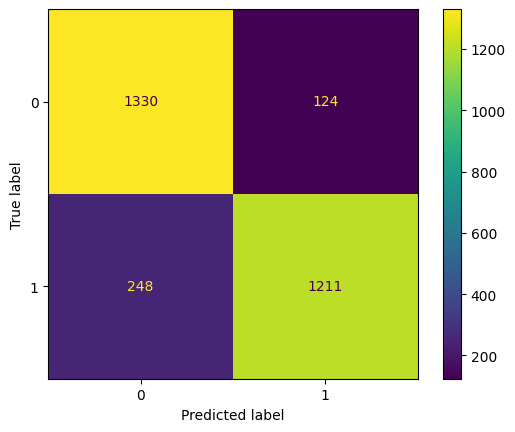

In [26]:
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [27]:
print(classification_report(y_train, clf_lreg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      5818
           1       0.92      0.85      0.88      5831

    accuracy                           0.89     11649
   macro avg       0.89      0.89      0.89     11649
weighted avg       0.89      0.89      0.89     11649



In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1454
           1       0.91      0.83      0.87      1459

    accuracy                           0.87      2913
   macro avg       0.87      0.87      0.87      2913
weighted avg       0.88      0.87      0.87      2913



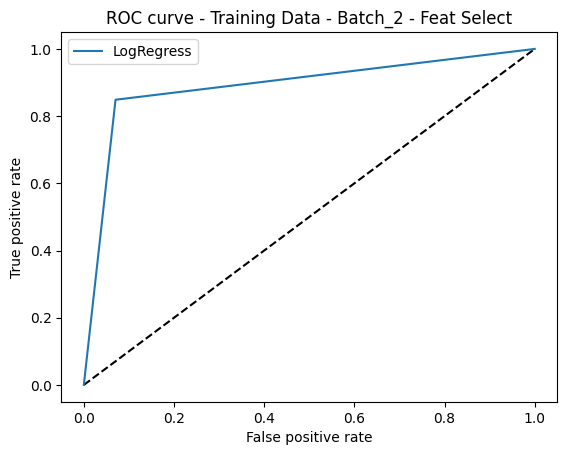

In [29]:
fpr_rf, tpr_rf, _ = roc_curve(y_train, clf_lreg.predict(X_train))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LogRegress')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Training Data - Batch_2 - Feat Select')
plt.legend(loc='best')
plt.show()

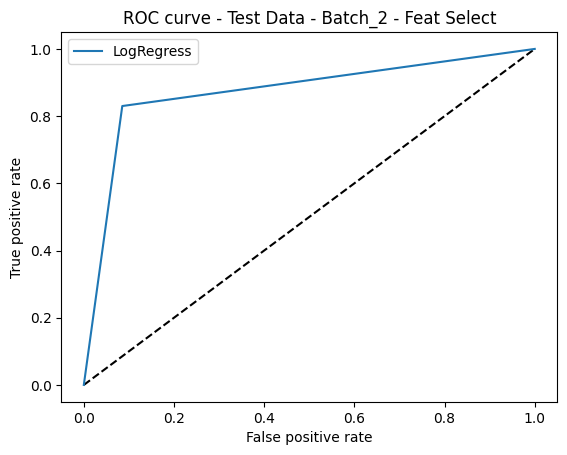

In [30]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf_lreg.predict(X_test))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LogRegress')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data - Batch_2 - Feat Select')
plt.legend(loc='best')
plt.show()

# Classification - Random Forest - Feature Selection

In [31]:
clf_RF = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [32]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

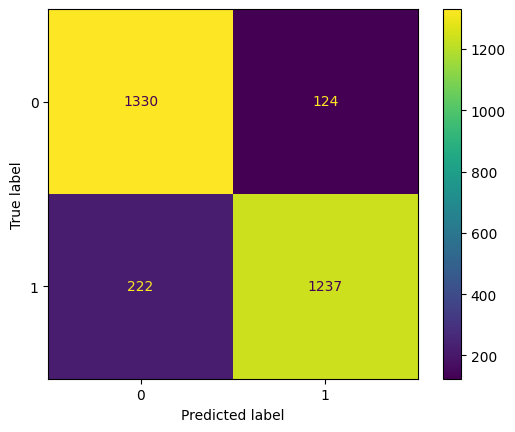

In [33]:
y_pred = clf_RF.predict(X_test)
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [34]:
print(classification_report(y_train, clf_RF.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5818
           1       1.00      1.00      1.00      5831

    accuracy                           1.00     11649
   macro avg       1.00      1.00      1.00     11649
weighted avg       1.00      1.00      1.00     11649



In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1454
           1       0.91      0.85      0.88      1459

    accuracy                           0.88      2913
   macro avg       0.88      0.88      0.88      2913
weighted avg       0.88      0.88      0.88      2913



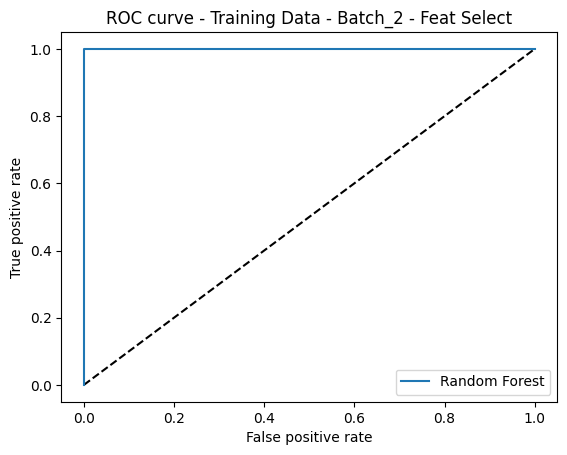

In [36]:
fpr_rf, tpr_rf, _ = roc_curve(y_train, clf_RF.predict(X_train))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Training Data - Batch_2 - Feat Select')
plt.legend(loc='best')
plt.show()

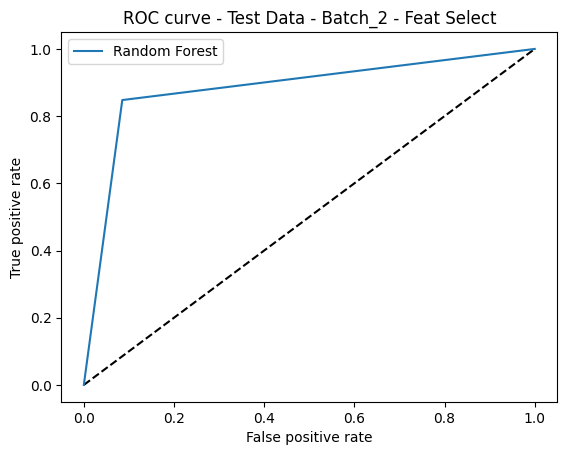

In [37]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf_RF.predict(X_test))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data - Batch_2 - Feat Select')
plt.legend(loc='best')
plt.show()

# Hyperparameter Tuning - Optuna


https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407


## Objective Function for Optuna - XGBoost

In [38]:
import xgboost as xgb

In [39]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    param = {
        'n_estimators'      : trial.suggest_int('n_estimators', 50, 500),
        'max_depth'         : trial.suggest_int('max_depth', 50, 500),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 1),
        'verbosity'         : 1,
        'random_state'      : 42,
        'extra_trees'       : True,
        "objective"         : "binary:logistic",
        "eval_metric"       : "auc",
        "booster"           : trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda"            : trial.suggest_float("lambda", 1e-8, 1.0),
        "alpha"             : trial.suggest_float("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy

## Run Optuna

In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1000)

[I 2023-04-05 00:39:13,434] A new study created in memory with name: no-name-2d4c70f7-2cbf-4364-a703-9e996f88f6a1


[00:39:13] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89364
[1]	validation-auc:0.90700
[2]	validation-auc:0.91776
[3]	validation-auc:0.92613
[4]	validation-auc:0.93130
[5]	validation-auc:0.93625
[6]	validation-auc:0.93728
[7]	validation-auc:0.93886
[8]	validation-auc:0.94032
[9]	validation-auc:0.94055


[I 2023-04-05 00:39:37,082] Trial 0 finished with value: 0.8795056642636457 and parameters: {'n_estimators': 457, 'max_depth': 58, 'learning_rate': 0.27811199793655045, 'booster': 'gbtree', 'lambda': 0.47959457439061814, 'alpha': 0.06944482085625157, 'eta': 0.22445158093202455, 'gamma': 0.9785311429597724, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8795056642636457.


[00:39:37] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-04-05 00:39:37,501] Trial 1 finished with value: 0.5008582217645039 and parameters: {'n_estimators': 272, 'max_depth': 353, 'learning_rate': 0.8377630298658696, 'booster': 'gblinear', 'lambda': 0.9624612109392413, 'alpha': 0.859950271679861}. Best is trial 0 with value: 0.8795056642636457.


[00:39:37] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89198
[1]	validation-auc:0.89807
[2]	validation-auc:0.91119
[3]	validation-auc:0.91988
[4]	validation-auc:0.92582
[5]	validation-auc:0.92995
[6]	validation-auc:0.93107
[7]	validation-auc:0.93406
[8]	validation-auc:0.93537
[9]	validation-auc:0.93654


[I 2023-04-05 00:40:02,609] Trial 2 finished with value: 0.871953312736011 and parameters: {'n_estimators': 261, 'max_depth': 369, 'learning_rate': 0.32683232075643487, 'booster': 'dart', 'lambda': 0.2002145708219519, 'alpha': 0.0770921238261696, 'eta': 0.5040839902789789, 'gamma': 0.5376405548761488, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.1181862122098541, 'skip_drop': 0.4518573034614163}. Best is trial 0 with value: 0.8795056642636457.


[00:40:02] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-04-05 00:40:03,040] Trial 3 finished with value: 0.5008582217645039 and parameters: {'n_estimators': 93, 'max_depth': 392, 'learning_rate': 0.7065311325363562, 'booster': 'gblinear', 'lambda': 0.27144743235535984, 'alpha': 0.29606386276056773}. Best is trial 0 with value: 0.8795056642636457.


[00:40:03] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-04-05 00:40:03,455] Trial 4 finished with value: 0.5008582217645039 and parameters: {'n_estimators': 122, 'max_depth': 360, 'learning_rate': 0.9513418156360212, 'booster': 'gblinear', 'lambda': 0.42522171889425847, 'alpha': 0.6216886181954502}. Best is trial 0 with value: 0.8795056642636457.


[00:40:03] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90253
[1]	validation-auc:0.91355
[2]	validation-auc:0.92470
[3]	validation-auc:0.93106
[4]	validation-auc:0.93342
[5]	validation-auc:0.93575
[6]	validation-auc:0.93856
[7]	validation-auc:0.93972
[8]	validation-auc:0.94104
[9]	validation-auc:0.94182


[I 2023-04-05 00:40:23,904] Trial 5 finished with value: 0.8753861997940268 and parameters: {'n_estimators': 59, 'max_depth': 279, 'learning_rate': 0.577336462263033, 'booster': 'gbtree', 'lambda': 0.7293816816210992, 'alpha': 0.10948740254564535, 'eta': 0.3826889540168907, 'gamma': 0.05962856841760827, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8795056642636457.


[00:40:24] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.



[I 2023-04-05 00:40:24,342] Trial 6 pruned. Trial was pruned at iteration 0.


[00:40:24] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89332
[1]	validation-auc:0.90864
[2]	validation-auc:0.91853
[3]	validation-auc:0.92582
[4]	validation-auc:0.93333
[5]	validation-auc:0.93645
[6]	validation-auc:0.93882
[7]	validation-auc:0.93936
[8]	validation-auc:0.94022
[9]	validation-auc:0.94115


[I 2023-04-05 00:40:47,171] Trial 7 finished with value: 0.8767593546172331 and parameters: {'n_estimators': 194, 'max_depth': 251, 'learning_rate': 0.3068040701882108, 'booster': 'dart', 'lambda': 0.46517186419910084, 'alpha': 0.5642353796915828, 'eta': 0.4089104843156278, 'gamma': 0.31916048743995507, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.5486795206310178, 'skip_drop': 0.9896756142443568}. Best is trial 0 with value: 0.8795056642636457.


[00:40:47] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89963
[1]	validation-auc:0.91539
[2]	validation-auc:0.92315
[3]	validation-auc:0.92698
[4]	validation-auc:0.93135
[5]	validation-auc:0.93223
[6]	validation-auc:0.93190
[7]	validation-auc:0.93362


[I 2023-04-05 00:41:11,441] Trial 8 pruned. Trial was pruned at iteration 7.


[00:41:11] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.50000


[I 2023-04-05 00:41:11,687] Trial 9 pruned. Trial was pruned at iteration 0.


[00:41:11] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.87745


[I 2023-04-05 00:41:19,124] Trial 10 pruned. Trial was pruned at iteration 0.


[00:41:19] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89797
[1]	validation-auc:0.90716
[2]	validation-auc:0.91864
[3]	validation-auc:0.92595
[4]	validation-auc:0.92997
[5]	validation-auc:0.93550
[6]	validation-auc:0.93800
[7]	validation-auc:0.93894
[8]	validation-auc:0.93953
[9]	validation-auc:0.94124


[I 2023-04-05 00:41:42,027] Trial 11 finished with value: 0.8767593546172331 and parameters: {'n_estimators': 369, 'max_depth': 71, 'learning_rate': 0.30818882641129786, 'booster': 'gbtree', 'lambda': 0.5401173971743312, 'alpha': 0.004185746077539479, 'eta': 0.2508830768427728, 'gamma': 0.4119301753976976, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8795056642636457.


[00:41:42] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89496
[1]	validation-auc:0.90953
[2]	validation-auc:0.91639
[3]	validation-auc:0.91909


[I 2023-04-05 00:41:54,741] Trial 12 pruned. Trial was pruned at iteration 3.


[00:41:54] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89751
[1]	validation-auc:0.91234


[I 2023-04-05 00:42:04,843] Trial 13 pruned. Trial was pruned at iteration 2.


[00:42:05] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89556
[1]	validation-auc:0.90919
[2]	validation-auc:0.91906
[3]	validation-auc:0.92426
[4]	validation-auc:0.92797


[I 2023-04-05 00:42:21,875] Trial 14 pruned. Trial was pruned at iteration 5.


[00:42:22] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89832
[1]	validation-auc:0.91213
[2]	validation-auc:0.92054
[3]	validation-auc:0.92710
[4]	validation-auc:0.92933
[5]	validation-auc:0.93444
[6]	validation-auc:0.93612
[7]	validation-auc:0.93590


[I 2023-04-05 00:42:41,660] Trial 15 pruned. Trial was pruned at iteration 7.


[00:42:41] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89728
[1]	validation-auc:0.90882
[2]	validation-auc:0.91968
[3]	validation-auc:0.92592
[4]	validation-auc:0.92931


[I 2023-04-05 00:42:59,358] Trial 16 pruned. Trial was pruned at iteration 5.


[00:42:59] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:43:02,406] Trial 17 pruned. Trial was pruned at iteration 0.


[00:43:02] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89497
[1]	validation-auc:0.90107


[I 2023-04-05 00:43:09,788] Trial 18 pruned. Trial was pruned at iteration 1.


[00:43:09] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89954
[1]	validation-auc:0.91380
[2]	validation-auc:0.92265
[3]	validation-auc:0.93037
[4]	validation-auc:0.93307
[5]	validation-auc:0.93583
[6]	validation-auc:0.93803
[7]	validation-auc:0.93979
[8]	validation-auc:0.94154
[9]	validation-auc:0.94290


[I 2023-04-05 00:43:30,275] Trial 19 finished with value: 0.8819086852042568 and parameters: {'n_estimators': 305, 'max_depth': 420, 'learning_rate': 0.39973489950408037, 'booster': 'gbtree', 'lambda': 0.3474962700318228, 'alpha': 0.3045443096685948, 'eta': 0.11432862640310813, 'gamma': 0.9948862946800998, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.8819086852042568.


[00:43:30] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89274


[I 2023-04-05 00:43:35,064] Trial 20 pruned. Trial was pruned at iteration 0.


[00:43:35] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89736
[1]	validation-auc:0.90973
[2]	validation-auc:0.91842
[3]	validation-auc:0.92592
[4]	validation-auc:0.93021


[I 2023-04-05 00:43:52,651] Trial 21 pruned. Trial was pruned at iteration 5.


[00:43:52] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89890
[1]	validation-auc:0.90989
[2]	validation-auc:0.91775


[I 2023-04-05 00:44:00,903] Trial 22 pruned. Trial was pruned at iteration 2.


[00:44:01] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89758
[1]	validation-auc:0.90977
[2]	validation-auc:0.92112
[3]	validation-auc:0.92746
[4]	validation-auc:0.93120
[5]	validation-auc:0.93279


[I 2023-04-05 00:44:18,006] Trial 23 pruned. Trial was pruned at iteration 5.


[00:44:18] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89368


[I 2023-04-05 00:44:23,646] Trial 24 pruned. Trial was pruned at iteration 1.


[00:44:23] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89283


[I 2023-04-05 00:44:28,271] Trial 25 pruned. Trial was pruned at iteration 0.


[00:44:28] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89736
[1]	validation-auc:0.91336
[2]	validation-auc:0.92296
[3]	validation-auc:0.92950
[4]	validation-auc:0.93359
[5]	validation-auc:0.93566
[6]	validation-auc:0.93818
[7]	validation-auc:0.93894
[8]	validation-auc:0.93992
[9]	validation-auc:0.94134


[I 2023-04-05 00:44:49,084] Trial 26 finished with value: 0.8753861997940268 and parameters: {'n_estimators': 147, 'max_depth': 91, 'learning_rate': 0.4745995038132018, 'booster': 'dart', 'lambda': 0.3910184631121079, 'alpha': 0.34426218243911066, 'eta': 0.08434069501822575, 'gamma': 0.7737395622508054, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2907130100503113, 'skip_drop': 0.7432823524996346}. Best is trial 19 with value: 0.8819086852042568.


[00:44:49] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.88704


[I 2023-04-05 00:44:52,261] Trial 27 pruned. Trial was pruned at iteration 0.


[00:44:52] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89815
[1]	validation-auc:0.91112


[I 2023-04-05 00:45:02,346] Trial 28 pruned. Trial was pruned at iteration 2.


[00:45:02] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89440


[I 2023-04-05 00:45:09,897] Trial 29 pruned. Trial was pruned at iteration 1.
[I 2023-04-05 00:45:10,182] Trial 30 pruned. Trial was pruned at iteration 0.


[00:45:10] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[00:45:10] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89863
[1]	validation-auc:0.90545


[I 2023-04-05 00:45:15,484] Trial 31 pruned. Trial was pruned at iteration 1.


[00:45:15] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89820
[1]	validation-auc:0.91044
[2]	validation-auc:0.91930
[3]	validation-auc:0.92848
[4]	validation-auc:0.93277
[5]	validation-auc:0.93636
[6]	validation-auc:0.93681


[I 2023-04-05 00:45:32,629] Trial 32 pruned. Trial was pruned at iteration 6.


[00:45:32] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89783
[1]	validation-auc:0.90765
[2]	validation-auc:0.92021


[I 2023-04-05 00:45:44,790] Trial 33 pruned. Trial was pruned at iteration 3.


[00:45:44] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90118
[1]	validation-auc:0.90960
[2]	validation-auc:0.92003
[3]	validation-auc:0.92772
[4]	validation-auc:0.93224
[5]	validation-auc:0.93634
[6]	validation-auc:0.93847
[7]	validation-auc:0.93894
[8]	validation-auc:0.94018
[9]	validation-auc:0.94147


[I 2023-04-05 00:46:07,354] Trial 34 finished with value: 0.8777892207346378 and parameters: {'n_estimators': 236, 'max_depth': 341, 'learning_rate': 0.4011972619007763, 'booster': 'gbtree', 'lambda': 0.6502125563470994, 'alpha': 0.14056719112276625, 'eta': 0.304867885709885, 'gamma': 0.3113513108906749, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.8819086852042568.


[00:46:07] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90057
[1]	validation-auc:0.90985
[2]	validation-auc:0.92242
[3]	validation-auc:0.92914
[4]	validation-auc:0.93398


[I 2023-04-05 00:46:21,347] Trial 35 pruned. Trial was pruned at iteration 5.


[00:46:21] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.50000


[I 2023-04-05 00:46:21,641] Trial 36 pruned. Trial was pruned at iteration 0.


[00:46:21] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89505
[1]	validation-auc:0.90890
[2]	validation-auc:0.92009
[3]	validation-auc:0.92787
[4]	validation-auc:0.93173


[I 2023-04-05 00:46:35,315] Trial 37 pruned. Trial was pruned at iteration 5.


[00:46:35] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.89707
[1]	validation-auc:0.89717


[I 2023-04-05 00:46:35,589] Trial 38 pruned. Trial was pruned at iteration 1.


[00:46:35] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89559
[1]	validation-auc:0.91104
[2]	validation-auc:0.92048


[I 2023-04-05 00:46:47,434] Trial 39 pruned. Trial was pruned at iteration 3.


[00:46:47] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89716
[1]	validation-auc:0.91175
[2]	validation-auc:0.92590
[3]	validation-auc:0.93203
[4]	validation-auc:0.93509
[5]	validation-auc:0.93871
[6]	validation-auc:0.94065
[7]	validation-auc:0.94213
[8]	validation-auc:0.94237
[9]	validation-auc:0.94256


[I 2023-04-05 00:47:07,451] Trial 40 finished with value: 0.8832818400274631 and parameters: {'n_estimators': 52, 'max_depth': 298, 'learning_rate': 0.47689761940356884, 'booster': 'gbtree', 'lambda': 0.4147381551253898, 'alpha': 0.2812340661147922, 'eta': 0.06560798600430276, 'gamma': 0.9321365273259589, 'grow_policy': 'depthwise'}. Best is trial 40 with value: 0.8832818400274631.


[00:47:07] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89715
[1]	validation-auc:0.90952
[2]	validation-auc:0.92216
[3]	validation-auc:0.92909
[4]	validation-auc:0.93378


[I 2023-04-05 00:47:22,128] Trial 41 pruned. Trial was pruned at iteration 5.


[00:47:22] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89767
[1]	validation-auc:0.91311
[2]	validation-auc:0.92220
[3]	validation-auc:0.92820
[4]	validation-auc:0.93172


[I 2023-04-05 00:47:35,694] Trial 42 pruned. Trial was pruned at iteration 4.


[00:47:35] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89766
[1]	validation-auc:0.90845
[2]	validation-auc:0.91751


[I 2023-04-05 00:47:45,150] Trial 43 pruned. Trial was pruned at iteration 2.


[00:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89602
[1]	validation-auc:0.90807
[2]	validation-auc:0.91877
[3]	validation-auc:0.92708


[I 2023-04-05 00:47:58,500] Trial 44 pruned. Trial was pruned at iteration 4.


[00:47:58] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89640
[1]	validation-auc:0.91095
[2]	validation-auc:0.92216
[3]	validation-auc:0.93099
[4]	validation-auc:0.93563
[5]	validation-auc:0.93696
[6]	validation-auc:0.93809
[7]	validation-auc:0.93521


[I 2023-04-05 00:48:15,437] Trial 45 pruned. Trial was pruned at iteration 7.


[00:48:15] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89816
[1]	validation-auc:0.91308
[2]	validation-auc:0.92335
[3]	validation-auc:0.93380
[4]	validation-auc:0.93824
[5]	validation-auc:0.93999
[6]	validation-auc:0.94158
[7]	validation-auc:0.94232
[8]	validation-auc:0.94347
[9]	validation-auc:0.94423


[I 2023-04-05 00:48:38,079] Trial 46 finished with value: 0.8815653964984552 and parameters: {'n_estimators': 335, 'max_depth': 273, 'learning_rate': 0.43375012272661995, 'booster': 'gbtree', 'lambda': 0.5070553176384128, 'alpha': 0.44031706481563077, 'eta': 0.04418977587548899, 'gamma': 0.9380308765399356, 'grow_policy': 'depthwise'}. Best is trial 40 with value: 0.8832818400274631.


[00:48:38] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89779
[1]	validation-auc:0.91340
[2]	validation-auc:0.92289
[3]	validation-auc:0.92893


[I 2023-04-05 00:48:51,929] Trial 47 pruned. Trial was pruned at iteration 4.


[00:48:52] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89340


[I 2023-04-05 00:48:55,470] Trial 48 pruned. Trial was pruned at iteration 0.


[00:48:55] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89269


[I 2023-04-05 00:48:59,034] Trial 49 pruned. Trial was pruned at iteration 0.


[00:48:59] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:49:04,254] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2023-04-05 00:49:04,508] Trial 51 pruned. Trial was pruned at iteration 0.


[00:49:04] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[00:49:04] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:49:08,005] Trial 52 pruned. Trial was pruned at iteration 0.


[00:49:08] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89996
[1]	validation-auc:0.91597
[2]	validation-auc:0.92522
[3]	validation-auc:0.93055
[4]	validation-auc:0.93419
[5]	validation-auc:0.93619
[6]	validation-auc:0.93670


[I 2023-04-05 00:49:27,557] Trial 53 pruned. Trial was pruned at iteration 6.


[00:49:27] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89487


[I 2023-04-05 00:49:32,625] Trial 54 pruned. Trial was pruned at iteration 0.


[00:49:32] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:49:35,771] Trial 55 pruned. Trial was pruned at iteration 0.


[00:49:35] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90102
[1]	validation-auc:0.90981


[I 2023-04-05 00:49:45,943] Trial 56 pruned. Trial was pruned at iteration 2.


[00:49:46] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90041
[1]	validation-auc:0.91586
[2]	validation-auc:0.92301
[3]	validation-auc:0.92652
[4]	validation-auc:0.93109


[I 2023-04-05 00:50:01,546] Trial 57 pruned. Trial was pruned at iteration 4.


[00:50:01] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89774
[1]	validation-auc:0.91005


[I 2023-04-05 00:50:11,885] Trial 58 pruned. Trial was pruned at iteration 2.


[00:50:12] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89595


[I 2023-04-05 00:50:15,294] Trial 59 pruned. Trial was pruned at iteration 0.


[00:50:15] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:50:18,547] Trial 60 pruned. Trial was pruned at iteration 0.


[00:50:18] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89767


[I 2023-04-05 00:50:26,225] Trial 61 pruned. Trial was pruned at iteration 1.


[00:50:26] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89683


[I 2023-04-05 00:50:29,648] Trial 62 pruned. Trial was pruned at iteration 0.


[00:50:29] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89219


[I 2023-04-05 00:50:32,894] Trial 63 pruned. Trial was pruned at iteration 0.


[00:50:33] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:50:37,834] Trial 64 pruned. Trial was pruned at iteration 0.


[00:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89979
[1]	validation-auc:0.90910
[2]	validation-auc:0.91884


[I 2023-04-05 00:50:48,606] Trial 65 pruned. Trial was pruned at iteration 3.


[00:50:48] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.89505


[I 2023-04-05 00:50:49,154] Trial 66 pruned. Trial was pruned at iteration 0.


[00:50:49] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:50:53,672] Trial 67 pruned. Trial was pruned at iteration 0.


[00:50:53] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89840
[1]	validation-auc:0.89840


[I 2023-04-05 00:50:59,836] Trial 68 pruned. Trial was pruned at iteration 1.


[00:51:00] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89464


[I 2023-04-05 00:51:04,696] Trial 69 pruned. Trial was pruned at iteration 0.


[00:51:05] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89367


[I 2023-04-05 00:51:08,682] Trial 70 pruned. Trial was pruned at iteration 0.


[00:51:08] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89860
[1]	validation-auc:0.90965
[2]	validation-auc:0.92138
[3]	validation-auc:0.92791


[I 2023-04-05 00:51:21,605] Trial 71 pruned. Trial was pruned at iteration 4.


[00:51:21] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89924
[1]	validation-auc:0.90581


[I 2023-04-05 00:51:27,465] Trial 72 pruned. Trial was pruned at iteration 1.


[00:51:27] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89309


[I 2023-04-05 00:51:32,950] Trial 73 pruned. Trial was pruned at iteration 0.


[00:51:33] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89740
[1]	validation-auc:0.91435
[2]	validation-auc:0.92602
[3]	validation-auc:0.93187
[4]	validation-auc:0.93614
[5]	validation-auc:0.93967
[6]	validation-auc:0.94165
[7]	validation-auc:0.94273
[8]	validation-auc:0.94289
[9]	validation-auc:0.94355


[I 2023-04-05 00:51:52,425] Trial 74 finished with value: 0.8746996223824236 and parameters: {'n_estimators': 243, 'max_depth': 298, 'learning_rate': 0.49138440209280004, 'booster': 'gbtree', 'lambda': 0.4875951601501008, 'alpha': 0.22817099003972463, 'eta': 0.32862925254288244, 'gamma': 0.429344264976461, 'grow_policy': 'depthwise'}. Best is trial 40 with value: 0.8832818400274631.


[00:51:52] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:51:55,678] Trial 75 pruned. Trial was pruned at iteration 0.


[00:51:55] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:52:01,110] Trial 76 pruned. Trial was pruned at iteration 0.


[00:52:01] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.90192


[I 2023-04-05 00:52:01,408] Trial 77 pruned. Trial was pruned at iteration 1.


[00:52:01] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89901
[1]	validation-auc:0.90861


[I 2023-04-05 00:52:07,430] Trial 78 pruned. Trial was pruned at iteration 1.


[00:52:07] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:52:10,300] Trial 79 pruned. Trial was pruned at iteration 0.


[00:52:10] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89072


[I 2023-04-05 00:52:15,182] Trial 80 pruned. Trial was pruned at iteration 0.


[00:52:15] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89904
[1]	validation-auc:0.91842
[2]	validation-auc:0.92666
[3]	validation-auc:0.93289
[4]	validation-auc:0.93578
[5]	validation-auc:0.93961
[6]	validation-auc:0.94101
[7]	validation-auc:0.94127
[8]	validation-auc:0.94296
[9]	validation-auc:0.94377


[I 2023-04-05 00:52:35,872] Trial 81 finished with value: 0.8733264675592173 and parameters: {'n_estimators': 192, 'max_depth': 51, 'learning_rate': 0.4782781191058802, 'booster': 'dart', 'lambda': 0.40583542663359623, 'alpha': 0.3520001287474885, 'eta': 0.07939407953176164, 'gamma': 0.9872162938604578, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.3261397693173778, 'skip_drop': 0.7577132874776706}. Best is trial 40 with value: 0.8832818400274631.


[00:52:36] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:52:40,857] Trial 82 pruned. Trial was pruned at iteration 0.


[00:52:41] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90223
[1]	validation-auc:0.91196
[2]	validation-auc:0.92129
[3]	validation-auc:0.92580


[I 2023-04-05 00:52:51,461] Trial 83 pruned. Trial was pruned at iteration 3.


[00:52:51] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89035


[I 2023-04-05 00:52:56,419] Trial 84 pruned. Trial was pruned at iteration 0.


[00:52:56] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89904
[1]	validation-auc:0.91208
[2]	validation-auc:0.91869


[I 2023-04-05 00:53:04,531] Trial 85 pruned. Trial was pruned at iteration 2.


[00:53:04] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89815
[1]	validation-auc:0.90801


[I 2023-04-05 00:53:12,356] Trial 86 pruned. Trial was pruned at iteration 1.


[00:53:12] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90055


[I 2023-04-05 00:53:18,204] Trial 87 pruned. Trial was pruned at iteration 1.


[00:53:18] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89810
[1]	validation-auc:0.91096
[2]	validation-auc:0.92103
[3]	validation-auc:0.92971
[4]	validation-auc:0.93446
[5]	validation-auc:0.93851
[6]	validation-auc:0.93921
[7]	validation-auc:0.94167
[8]	validation-auc:0.94177
[9]	validation-auc:0.94238


[I 2023-04-05 00:53:41,903] Trial 88 finished with value: 0.8795056642636457 and parameters: {'n_estimators': 287, 'max_depth': 484, 'learning_rate': 0.3441107515305727, 'booster': 'gbtree', 'lambda': 0.47601988818025204, 'alpha': 0.24956519998820836, 'eta': 0.10668623992026283, 'gamma': 0.8916002984576432, 'grow_policy': 'lossguide'}. Best is trial 40 with value: 0.8832818400274631.


[00:53:42] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:53:45,402] Trial 89 pruned. Trial was pruned at iteration 0.


[00:53:45] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:53:50,456] Trial 90 pruned. Trial was pruned at iteration 0.


[00:53:50] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89733


[I 2023-04-05 00:53:53,842] Trial 91 pruned. Trial was pruned at iteration 0.


[00:53:54] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.



[I 2023-04-05 00:53:57,397] Trial 92 pruned. Trial was pruned at iteration 0.


[00:53:57] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89178


[I 2023-04-05 00:54:03,060] Trial 93 pruned. Trial was pruned at iteration 0.


[00:54:03] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.90049
[1]	validation-auc:0.91670
[2]	validation-auc:0.92555
[3]	validation-auc:0.93243
[4]	validation-auc:0.93539
[5]	validation-auc:0.93687
[6]	validation-auc:0.93888
[7]	validation-auc:0.93967
[8]	validation-auc:0.94042
[9]	validation-auc:0.94153


[I 2023-04-05 00:54:23,360] Trial 94 finished with value: 0.8767593546172331 and parameters: {'n_estimators': 278, 'max_depth': 264, 'learning_rate': 0.4686803679800837, 'booster': 'gbtree', 'lambda': 0.5320053034753351, 'alpha': 0.26363180693666366, 'eta': 0.08917799552595931, 'gamma': 0.9282980247018203, 'grow_policy': 'depthwise'}. Best is trial 40 with value: 0.8832818400274631.


[00:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89896
[1]	validation-auc:0.91485
[2]	validation-auc:0.92585
[3]	validation-auc:0.93179
[4]	validation-auc:0.93584
[5]	validation-auc:0.93883
[6]	validation-auc:0.94037
[7]	validation-auc:0.94119
[8]	validation-auc:0.94227
[9]	validation-auc:0.94369


[I 2023-04-05 00:54:45,322] Trial 95 finished with value: 0.8801922416752489 and parameters: {'n_estimators': 294, 'max_depth': 261, 'learning_rate': 0.44271477940932347, 'booster': 'gbtree', 'lambda': 0.537797627892472, 'alpha': 0.24164066066640236, 'eta': 0.09645084585807678, 'gamma': 0.3527322234856678, 'grow_policy': 'lossguide'}. Best is trial 40 with value: 0.8832818400274631.


[00:54:45] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89896
[1]	validation-auc:0.91411
[2]	validation-auc:0.92330
[3]	validation-auc:0.92650


[I 2023-04-05 00:54:56,943] Trial 96 pruned. Trial was pruned at iteration 3.


[00:54:57] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89434


[I 2023-04-05 00:55:00,421] Trial 97 pruned. Trial was pruned at iteration 0.


[00:55:00] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89896
[1]	validation-auc:0.91528
[2]	validation-auc:0.92414


[I 2023-04-05 00:55:12,375] Trial 98 pruned. Trial was pruned at iteration 3.


[00:55:12] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.89445


[I 2023-04-05 00:55:15,705] Trial 99 pruned. Trial was pruned at iteration 0.


## Best XGBoost Model from Optuna

In [41]:
study.best_params

{'n_estimators': 52,
 'max_depth': 298,
 'learning_rate': 0.47689761940356884,
 'booster': 'gbtree',
 'lambda': 0.4147381551253898,
 'alpha': 0.2812340661147922,
 'eta': 0.06560798600430276,
 'gamma': 0.9321365273259589,
 'grow_policy': 'depthwise'}

In [42]:
clf_xgb_opt= XGBClassifier(**study.best_params)

In [43]:
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(alpha=0.2812340661147922, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06560798600430276,
              eval_metric=None, feature_types=None, gamma=0.9321365273259589,
              gpu_id=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=0.4147381551253898,
              learning_rate=0.47689761940356884, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=298, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=52, n_jobs=None, ...)

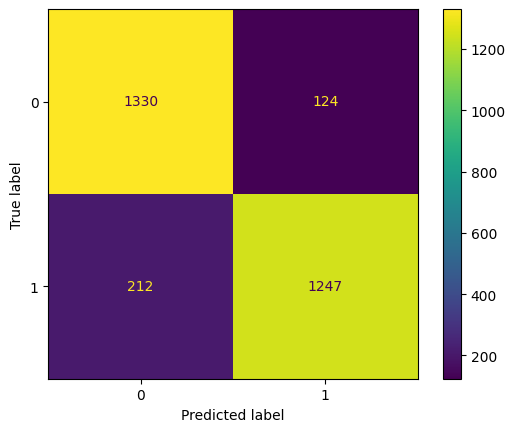

In [44]:
y_pred = clf_xgb_opt.predict(X_test)
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [46]:
print(classification_report(y_train, clf_xgb_opt.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5818
           1       1.00      1.00      1.00      5831

    accuracy                           1.00     11649
   macro avg       1.00      1.00      1.00     11649
weighted avg       1.00      1.00      1.00     11649



In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1454
           1       0.91      0.85      0.88      1459

    accuracy                           0.88      2913
   macro avg       0.89      0.88      0.88      2913
weighted avg       0.89      0.88      0.88      2913



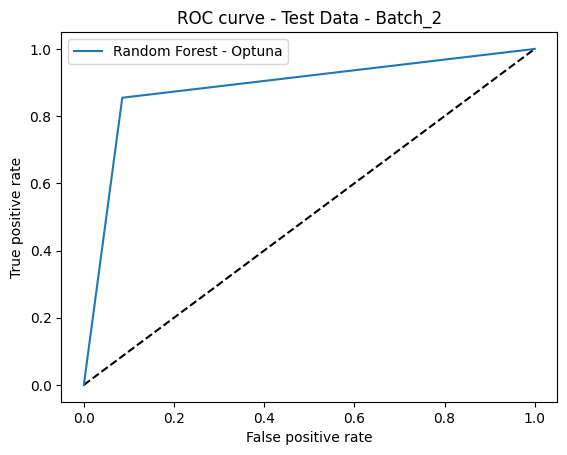

In [48]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf_xgb_opt.predict(X_test))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest - Optuna')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data - Batch_2')
plt.legend(loc='best')
plt.show()